# <div align="center">  Power Spectral Density Estimation </div>


# Description
You are given an audio file that contains a chord (played three times) recorded from a piano. A chord, in any
musical instrument, consists of two or more (usually three or more) notes (also called
“pitches”) that are heard as if sounding simultaneously. Some background on piano notes
is given in the Appendix on page 5. Your task is to detect all the notes in the given chord.
To do this, a possible method is to estimate the power spectral density (PSD) of the signal.



# Tasks
1. Download the audio file provided in the Brighspce portal for this assignment (i.e. the "PianoChord.wav"). You can play
this audio file using any media player available to you to hear the chord. To read the audio file in Python, you can use the following code

In [2]:
from scipy.io import wavfile
Fs, data = wavfile.read('PianoChord.wav')
print("The sampling rate is %f" %Fs) # print out the sampling rate of the audio file

The sampling rate is 48000.000000


/var/folders/tf/55bs9rt53nb95gvg8bx368f00000gn/T/ipykernel_32620/1046975494.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wavfile.read('PianoChord.wav')


The following cell plots the waveform (i.e. the time domain representation) of the sound.

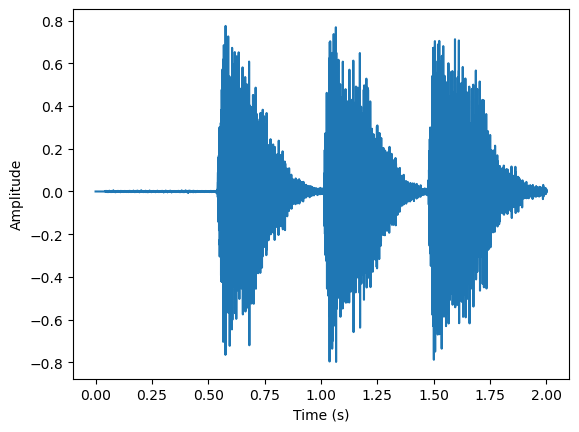

In [3]:
import matplotlib.pyplot as plt
import numpy as np
N = data.size ## number of samples
plt.plot(np.arange(N)/Fs, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

2.  Write Python code to compute the periodogram to estimate the PSD of the given  signal and give your comments. This task is done for you as a starting point. See the code below.

In [4]:
from numpy import fft as fft #import the FFT module from numpy package
N = len(data)
DFTofSignal = fft.fft(data) # compute DFT
PeriodogramData = ((np.abs(DFTofSignal))**2)/(N)

Now plot the periodogram

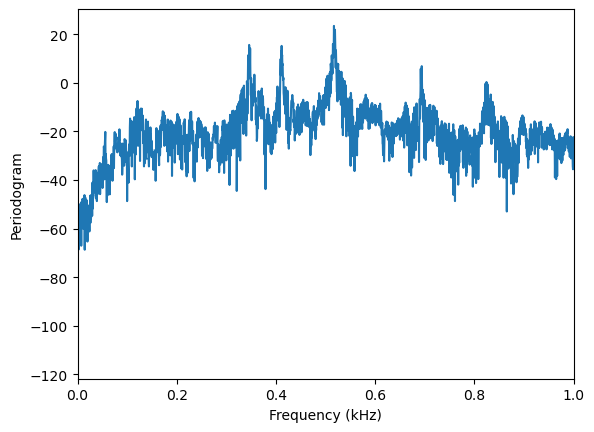

In [5]:
w = np.arange(N)/N # the normalised frequency.
f = w*Fs; # the continuous-time frequency. 
plt.plot(f/1e3, 10*np.log10(PeriodogramData))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Periodogram')
plt.xlim(0,1)
plt.show()

As we can see the periodogram yields a very noisy estimated of the PSD of the considered signal.

From examining the above noisy PSD, it can be seen that the peaks occur between 300-900Hz.
At this frequency range the smallest difference between each note is about about 17Hz, but looking at the range between 200-300Hz, the smallest variation is about 13Hz, which would imply a frequency resolution of about 6.5Hz would be the bare minimum. This is bare minimum, but with such a little frequency resolution it would be difficult to tell each note apart by eye, so a preferrably frequency resolution would be 2.5-5Hz
$ \\ N=\frac{F_s}{f_{res}} $
$ \\ N - number of samples $
$ \\ F_s = 48kHz - sampling frequency $
$ \\ f_{res} - frequency resolution $
$ \\ N_{min}=\frac{48\times 10^3}{6.5} = 7384 $
$ \\ N_{reccomended-optimum}=\frac{48\times 10^3}{2.5} = 19200 $
$ \\ N_{reccomended-min}=\frac{48\times 10^3}{5} = 9600 $
The FFT works best when the number of samples is a power of 2, so the minimum number of samples is as follows:
$ \\ N_{min} = 8192 = 2^{13} $
$ \\ N_{reccomended-optimum}= 32768 = 2^{15} $
$ \\ N_{reccomended-min}= 16384 = 2^{14} \\$
The Welch method is type of avaeraging method, so increasing the number K, which is number of segments it broken down to will decrease the noise seen in the signal as such choosing $N_{reccomended-min}$ would be better for noise reduction, this is $L$, in the equation for the welch method. The limit on L is based on the length of the data samples, which is only 96000 samples, so if L is too high, the noise reduction would be poor even if we have a good frequency resolution (basically would have a slightly improved version of the above)

The next parameter to take into account would D, for noise reduction, as what is happening in the welch method is that the noise is a constant value, so as it gets averaged the noise component will decrease, for this increasing D would be quite good, as this would mean the noise decreases. Now assuming we fix L, varying D is the next important thing, with a 50% overlap, this would mean 11 samples, which is effectively reducing the noise by a factor of 11, now increasing D to 75% would give 21 segments, which again decreasing the noise by a factr of 21. 
$ \\ s(t) = signal + noise $ 

Now if we have many samples, the noise should be small in comparison to the signal, so by averaging what we are effecively getting is just the signal itself. That is why the welch method is superior to the Bartlett method, as the welch method gives more segments, which in turn means a higher decrease of noise.

In this case by trial and error, a 50% overlap was deemed more than sufficient, as the purpose of the assignment is to find the chords, and this much overlap allowed me to identify the notes, which in turn allowed me detect the chord. Any higher overlap would be considered a waste of memory.

3. Write a Python code implementing Welch’s method to produce a PSD estimate of
the given chord, from which you will detect all the notes. Plot the obtained estimated PSD of the signal. Compare the estimated PSD obtained in this task with that in Task 2.

<function matplotlib.pyplot.show(close=None, block=None)>

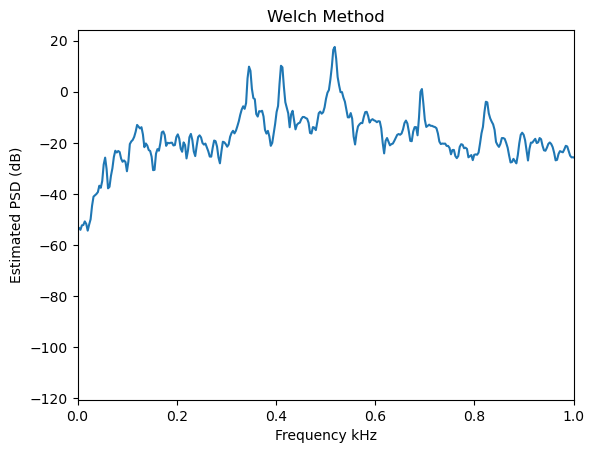

In [6]:
from operator import mod
from numpy import fft as fft #import the FFT module from numpy package
k = 0
N = len(data)
L=2**14 # number of samples per segment
D = int(0.5*L) # 50% samples - overlap between this segment and previous segment
w = np.hanning(L) # Window function
nSegs =0
AvgPeriodagram =0
# k must be less than N-L, as the last segment could not carry all of it, so process it later
while k<N-L:
    currSeg = data[k:k+L] # from k to k+(L-1) samples, i.e. L-1 Samples
    # Once data has been acquired multiply by window function
    currSeg = currSeg*w
    # Now get FFT of current sample
    DFTofCurrentSegment = fft.fft(currSeg) # compute DFT
    PeriodogramCurrSeg = ((np.abs(DFTofCurrentSegment))**2)/(L)
    # Add each of the periodagrams
    AvgPeriodagram = AvgPeriodagram+PeriodogramCurrSeg
    nSegs += 1
    # shift k back for overlapping, depnding on D
    k += L-D

# Sort last segment by zero padding
# Number of 0s to pad is k+L-N
zeros_toPad = k+L-N
currSeg = data[k:N]
#currSeg = np.concatenate([currSeg, np.zeros(zeros_toPad)])
currSeg = np.pad(currSeg, (0,zeros_toPad), 'constant')
# Multiply after appending 0s, it is still same, makes it easier as lengths would be same aswell
currSeg = currSeg*w
# Now get FFT of current sample
DFTofCurrentSegment = fft.fft(currSeg) # compute DFT
PeriodogramCurrSeg = ((np.abs(DFTofCurrentSegment))**2)/(L)
# Add each of the periodagrams
AvgPeriodagram = AvgPeriodagram+PeriodogramCurrSeg
nSegs += 1

# Get energy of the window function
# First get Sum of each point and square
sum_wn_squared = 0
i =0
while i < L:
    sum_wn_squared += w[i]**2
    i += 1

U = 1/L * sum_wn_squared
# Average the periodogram
AvgPeriodagram = AvgPeriodagram/(nSegs*U)

# Plot periodogram
w = np.arange(L)/L
f = w*Fs
plt.plot(f/1e3, 10*np.log10(AvgPeriodagram))
#plt.plot(f/1e3, (AvgPeriodagram))
plt.xlabel('Frequency kHz')
plt.ylabel('Estimated PSD (dB)')
plt.title("Welch Method")
plt.xlim(0,1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

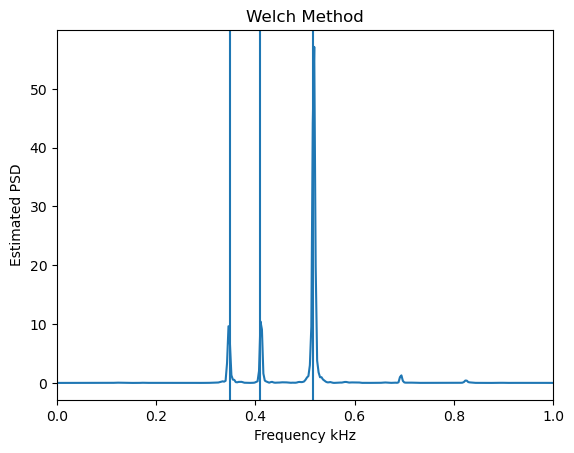

In [7]:
#To find the correct chord
plt.plot(f/1e3, (AvgPeriodagram))
plt.axvline(x=0.517)
plt.axvline(x=0.41)
plt.axvline(x=0.349)
plt.xlabel('Frequency kHz')
plt.ylabel('Estimated PSD')
plt.title("Welch Method")
plt.xlim(0,1)
plt.show

The peaks correspond to the approximate frequencies of 517Hz, 410Hz, 349Hz
The nearest notes to these are (https://en.wikipedia.org/wiki/Piano_key_frequencies ):

349.2282: F4

415.3047: G♯4/A♭4

523.2511: C5

Now inputting these notes notes into the following link, the accompanying chord can be found:

https://www.scales-chords.com/chord/piano/Fm

Now to double check, the following link is used:

http://www.piano-keyboard-guide.com/f-minor-chord.html

Now by using both sources, it can be confirmed that the chord played is F minor.
The variation between the perfect note and the note corresponding to the peaks are due to maybe the noise produced by the recording device (or maybe the ADC is not fast enough, or sum filtering of the recording device add some noise), or the piano may not be perfectly tuned, hence the notes are not perfect.

4. The SciPy package contains a built-in function "welch" which indeed estimates power spectral density using Welch’s method.  You can find the documentation of the welch function here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch. Compare your method with this built-in function.

<function matplotlib.pyplot.show(close=None, block=None)>

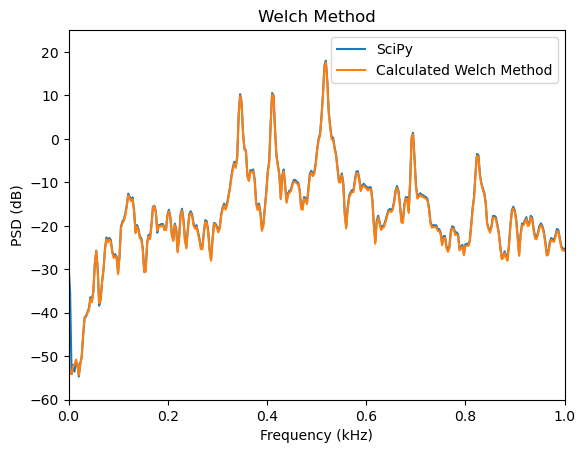

In [8]:
# Compare results from built in function
from scipy import signal as sci
import numpy as np
# Using builting function, ensuring that both sides are aquired, otherwise the single sided would not have the twice the power as the double sided
f,Pxx =sci.welch(data, fs=1.0, window='hann', nperseg=L, noverlap =D, return_onesided=False)
# Plotting both for comparison
plt.plot(f*Fs/1e3,10*np.log10(Pxx))
plt.plot(f*Fs/1e3,10*np.log10(AvgPeriodagram))
plt.ylabel("PSD (dB)")
plt.xlabel("Frequency (kHz)")
plt.xlim(0,1)
plt.ylim(-60,25)
plt.legend(["SciPy", "Calculated Welch Method"])
plt.title("Welch Method")
plt.show

In [9]:
# Find the variation between scipy and calculation avaerage welch
from ctypes import sizeof
variation = sum(abs(AvgPeriodagram-Pxx))/len(AvgPeriodagram)
print("There is a variation of: ")
print(variation*100) 
print("between the calculated and built in function")

There is a variation of: 
0.26034186538586646
between the calculated and built in function


It is quite interesting, by varying the size of D to 99%, the variation between the calculated and built in function becomes 0.0055%, with D=50%, the variaition becomes 0.26%.
So what I believe is happening is that the builtin function is using zero padding to the length L, to get a better frequency resolution. Testing hypothesis below.

<function matplotlib.pyplot.show(close=None, block=None)>

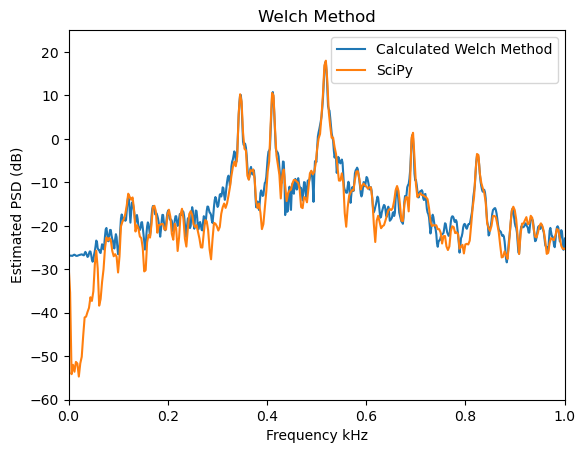

In [10]:
from operator import mod
from numpy import fft as fft #import the FFT module from numpy package
k = 0
N = len(data)
L=2**14 # number of samples per segment
D = int(0.5*L) # 50% samples

nSegs =0
AvgPeriodagram =0
zeros_toAppend = L*1
w = np.hanning(L+zeros_toAppend) # Window function
# k must be less than N-L, as the last segment could not carry all of it, so process it later
while k<N-L:
    currSeg = data[k:k+L] # from k to k+(L-1) samples, i.e. L-1 Samples
    currSeg = np.pad(currSeg, (0,zeros_toAppend), 'constant')
    # Once data has been acquired multiply by window function
    currSeg = currSeg*w
    
    # Now get FFT of current sample
    DFTofCurrentSegment = fft.fft(currSeg) # compute DFT
    PeriodogramCurrSeg = ((np.abs(DFTofCurrentSegment))**2)/(L)
    # Add each of the periodagrams
    AvgPeriodagram = AvgPeriodagram+PeriodogramCurrSeg
    nSegs += 1
    # shift k back for overlapping, depnding on D
    k += L-D

# Sort last segment by zero padding
# Number of 0s to pad is k+L-N
zeros_toPad = k+L-N+zeros_toAppend
currSeg = data[k:N]
#currSeg = np.concatenate([currSeg, np.zeros(zeros_toPad)])
currSeg = np.pad(currSeg, (0,zeros_toPad), 'constant')
# Multiply by window
currSeg = currSeg*w
# Now get FFT of current sample
DFTofCurrentSegment = fft.fft(currSeg) # compute DFT
PeriodogramCurrSeg = ((np.abs(DFTofCurrentSegment))**2)/(L)
# Add each of the periodagrams
AvgPeriodagram = AvgPeriodagram+PeriodogramCurrSeg
nSegs += 1

# Get energy of the window function
# First get Sum of each point and square
sum_wn_squared = 0
i =0
while i < L:
    sum_wn_squared += w[i]**2
    i += 1

U = 1/L * sum_wn_squared
# Average the periodogram
AvgPeriodagram = AvgPeriodagram/(nSegs*U)

# Plot periodogram
w = np.arange(L+zeros_toAppend)/(L+zeros_toAppend)
f = w*Fs
plt.plot(f/1e3, 10*np.log10(AvgPeriodagram))
#plt.plot(f/1e3, (AvgPeriodagram))
plt.xlabel('Frequency kHz')
plt.ylabel('Estimated PSD (dB)')
plt.title("Welch Method")
plt.xlim(0,1)
# Scipy
from scipy import signal as sci
import numpy as np
f,Pxx =sci.welch(data, fs=1.0, window='hann', nperseg=L, noverlap =D, return_onesided=False)
plt.plot(f*Fs/1e3,10*np.log10(Pxx))
plt.xlim(0,1)
plt.ylim(-60,25)
plt.legend(["Calculated Welch Method","SciPy"])
plt.show

From examining the zero-padded version, it can be concluded that the improvement is not due zero-padding. The variation is not signicant enough to find the cause of it.

# Rules
- You are NOT allowed to use the built-in “welch” function mentioned above as part of your method. However you can use it for benchmarking purposes.

- You cannot use any other audio processing or note detection software.

- You  can use standard signal processing commands such as those performing correlations, convolutions, filtering and FFTs if needed. If any doubt, you need to contact the coordinator for clarification.

- You can display intermediate results (data and plots) on screen to see how your algorithm is progressing.

# Appendix
When a particular note is played on a musical instrument not only is the fundamental frequency (tone) generated but also higher harmonics of the fundamental, i.e., pure tones at the frequencies $2f, 3f, 4f,\ldots$ These harmonics give the instrument a richer sound. For example the DFT of a piano middle C (commonly known as “C4”) is illustrated in the following figure.
<p align="center">
    <img src="FFTC4.png">
</p>

As the frequency of C4 is ≈ 261 Hz, we can see that the DFT shown in the figure above has peaks at 261 Hz and at higher harmonics. The frequencies of a standard (i.e. 88-key) piano can be found at the following link: [https://en.wikipedia.org/wiki/Piano_key_frequencies](https://en.wikipedia.org/wiki/Piano_key_frequencies).